# Synthetic Glacier: Preprocessing

Lets extract some data along a flowline for our Synthetic Glacier. Information we will extract:  
  * Surface profile from SRTM DEM  
  * Bedrock profile from Faranotti et al. 2019
  * Surface Mass Balance (SMB) from Erik Young's Enhanced temperature index melt model. 

In [403]:
import os
import numpy as np
import geopandas as gpd
import contextily as ctx
import cartopy.crs as ccrs

import scipy.signal as signal
from scipy import linalg as LA
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import fiona
import rasterio
import rasterio.mask
from rasterio.io import MemoryFile
from rasterio.transform import Affine

plt.rcParams['text.usetex'] = True

In [404]:
def centerline_2_points(geom, dx=30):
    # https://stackoverflow.com/questions/34906124/interpolating-every-x-distance-along-multiline-in-shapely
    num_vert = int(round(geom.length / dx))
    if num_vert == 0: 
        num_vert = 1
    multipoint = [geom.interpolate(float(n)/num_vert,normalized=True) for n in range(num_vert + 1)] 
    Latx = [multipoint[i].x for i in range(len(multipoint))]
    Laty = [multipoint[i].y for i in range(len(multipoint))]
    gdf  = gpd.GeoDataFrame(geometry=gpd.points_from_xy(Latx,Laty))
    return gdf

def lstq(x,y,order):
    A     = np.vstack([x**i for i in range(0,order)]).T
    coefs = LA.lstsq(A,y)[0]
    return coefs

In [406]:
FL_dir = '/Users/andrewnolan/sfuvault/LilKluane/flowlines/'

# FL1_fp = os.path.join(FL_dir,'manual/surge_trib/surge_trib.shp')
# FL2_fp = os.path.join(FL_dir,'manual/main/Little_Kluan_FL_main.shp')
# FL3_fp = os.path.join(FL_dir,'alexis/centerlines_postsurge_UTM7N.shp')

SURGE_TRIB = True
if SURGE_TRIB:
    FL_fp = os.path.join(FL_dir,'alexis/centerlines_postsurge_UTM7N.shp')
    # Read the centerline for Little Kluane
    LK_FL = gpd.read_file(FL_fp)
    LK_CP = centerline_2_points(LK_FL[LK_FL['MAIN'] == 1],dx=100)
    # For whatever reason we need to flip the oggm flowline
    LK_CP = LK_CP.sort_index(axis=0,ascending=False).reset_index(drop=True)
else:
    FL_fp = os.path.join(FL_dir,'manual/main/Little_Kluan_FL_main.shp')
    # Read the centerline for Little Kluane
    LK_FL = gpd.read_file(FL_fp)
    LK_CP = centerline_2_points(LK_FL,dx=100)

    

LK_CP['UTM_N'] = None
LK_CP['UTM_E'] = None

for i,row in enumerate(LK_CP['geometry']):
    LK_CP.iloc[i,1] = row.y
    LK_CP.iloc[i,2] = row.x   
prof_coords = [(x,y) for x, y in zip(LK_CP.UTM_E, LK_CP.UTM_N)]


In [434]:
BED_DEM_fp  = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/Faranotti_2020/RGI60-01.16198_BDEM.tif'

#SURF_DEM_fp = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/Faranotti_2020/surface_DEM_RGI60-01.16198.tif'
#SURF_DEM_fp = os.path.join(FL_dir,'src_data/ASTGTMV003_N60W140_dem_UTM7N.tif')
SURF_DEM_fp = '../DEMs/dem_2007.tif'
#SURF_DEM_fp = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/Faranotti_2020/surface_DEM_RGI60-01.16198.tif'

THIC_DEM_fp = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/Faranotti_2020/RGI60-01.16198_thickness.tif'
base_img_fp = '/Users/andrewnolan/Documents/SFU/courses/EASC_605/Projects/project_3/geodata/T07VEH_20190908T205019_B08.jp2'

In [435]:
with rasterio.open(SURF_DEM_fp) as src:
    LK_CP['surface'] = [x for x in src.sample(prof_coords)]
    LK_CP['surface'] = LK_CP.apply(lambda x: x['surface'][0], axis=1)
    
with rasterio.open(BED_DEM_fp) as src:
    LK_CP['bedprof'] = [x for x in src.sample(prof_coords)]
    LK_CP['bedprof'] = LK_CP.apply(lambda x: x['bedprof'][0], axis=1)

with rasterio.open(THIC_DEM_fp) as src:
    LK_CP['thickness'] = [x for x in src.sample(prof_coords)]
    LK_CP['thickness'] = LK_CP.apply(lambda x: x['thickness'][0], axis=1)

# Replace nodata with np.nan
LK_CP = LK_CP.replace(-9999.0,np.nan)

In [436]:
MB     = np.load('../Data/surgio_withdeb_NMB.npy') # annual mass balance data from EMY
XX     = np.load('../Data/surgio_Xs.npy')          # UTM 7N Easting  coords
YY     = np.load('../Data/surgio_Ys.npy')          # UTM 7N Northing coords
ZZ     = np.load('../Data/surgio_Zs.npy')          # Elevation used by EMY

MB     = np.mean(MB,axis=0)                        # Annual mean mass balance
masked = np.ma.masked_array(MB, np.isnan(MB))      # Mask the no-data values

In [437]:
xres      = XX[0,1] - XX[0,0] 
yres      = YY[1,0] - YY[0,0] 
transform = Affine.translation(XX.min(), YY.max()) * Affine.scale(xres, -yres)

# Dictionary of projection related params for georefrencings
kwags = { 'driver'    :'GTiff', 
          'height'    : MB.shape[0], 
          'width'     : MB.shape[1], 
          'count'     : 1, 
          'dtype'     : MB.dtype, 
          'crs'       : '+proj=utm +zone=7 +datum=WGS84 +units=m +no_defs', 
          'transform' : transform
        }

# Write the data to temp file 
with MemoryFile() as memfile:
    kwags['dtype'] = 'float64'
    with memfile.open(**kwags) as src:
        src.write(MB.data,1)
        LK_CP['bdot'] = [x for x in src.sample(prof_coords)]
        LK_CP['bdot'] = LK_CP.apply(lambda x: x['bdot'][0], axis=1)

(-7.0, 3.3491631355550555)

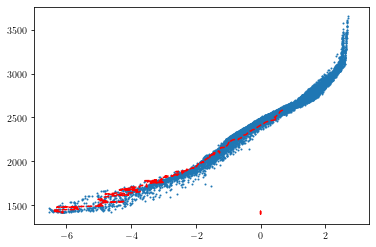

In [438]:
plt.scatter(MB,ZZ,s=1)
plt.plot(LK_CP['bdot'],LK_CP['surface'],'r--')

plt.xlim(-7,None)

# Raw Data from DEMs

In [439]:
# x-coordinate in m 
x_coord = LK_CP.index.to_numpy() * 100.0 / 1000.0

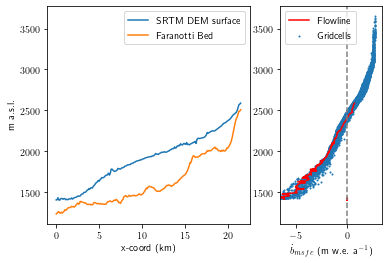

In [440]:
fig = plt.figure()
gs  = GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharey=ax1)

ax1.plot(x_coord,LK_CP['surface'],label='SRTM DEM surface')
ax1.plot(x_coord,LK_CP['bedprof'],label='Faranotti Bed')   
ax1.set_ylabel('m a.s.l.')
ax1.set_xlabel('x-coord (km)')

ax1.legend()

ax2.scatter(MB,ZZ,s=1,label='Gridcells')
ax2.plot(LK_CP['bdot'],LK_CP['surface'],'r',label='Flowline') 
ax2.axvline(0,linestyle='--',color='grey')
ax2.set_xlabel('$\dot b_{\rm sfc}$ (m w.e. a$^{-1}$)')
ax2.set_xlim(-6.5,None)
ax2.legend()

__Note__: Because Faranotit et al 2019 assume Little Kluane to be connected to the main Kluane Glacier, the ice thickness never reaches zero at the glacier margin. As a crude appoximation, we assume the glacier reaches zero ice-thickness arounf 18 km. Therefore, we manually force the bed and surface profiles to be equal after that point. 

In [441]:

surface       = LK_CP['surface'].copy()
bedprof       = LK_CP['bedprof'].copy()
surface[:34]  = LK_CP['bedprof'][:34]
#surface[0:22] = LK_CP['bedprof'][0:22]


Lets check extracted thickness along our flowline versus extracated values from faranotti to make sure we don't have any errors.

In [445]:
surface[-20:]

196    2345.0
197    2348.0
198    2356.0
199    2366.0
200    2373.0
201    2379.0
202    2388.0
203    2398.0
204    2412.0
205    2425.0
206    2441.0
207    2451.0
208    2460.0
209    2466.0
210    2479.0
211    2501.0
212    2534.0
213    2570.0
214    2577.0
215    2589.0
Name: surface, dtype: float64

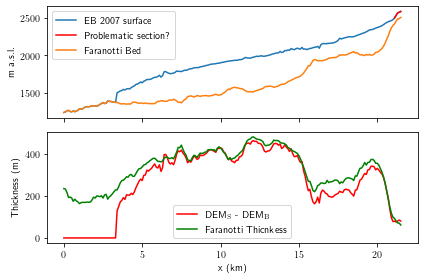

In [450]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(x_coord,surface,label='EB 2007 surface')
ax[0].plot(x_coord[-5:], surface[-5:],'r',label='Problematic section?')
ax[0].plot(x_coord,bedprof,label='Faranotti Bed')   
ax[0].legend()

ax[0].set_ylabel('m a.s.l.')

ax[1].plot(x_coord, surface-bedprof, 'r', label= 'DEM$_{\\rm S}$ - DEM$_{\\rm B}$')
ax[1].plot(x_coord, LK_CP['thickness'], 'g', label='Faranotti Thicnkess')
ax[1].legend()

ax[1].set_xlabel('x (km)')
ax[1].set_ylabel('Thickness (m)')

fig.tight_layout()
fig.savefig('../plots/icethicknes_check.png', dpi=200,bbox_inches='tight')

In [423]:
xx     = np.linspace(x_coord[-1],x_coord[0],surface.shape[0])    # [  ] new x-coord vector
dx     = xx.shape[0]-len(x_coord)                                # [  ] differnce in nx b/w original and new extend

# Empty extended surface (ss) and bed (bb) vectors to be filled
ss     = xx.copy()
bb     = xx.copy()

# Smooth Faranotti Bed Profile with Savgol Filter.
bb = signal.savgol_filter(x=bedprof,window_length=21, polyorder=5)   

# Fit 10th order polynomial to surface profile
ss = np.polyval(lstq(x_coord[~surface.isna()], surface[~surface.isna()],10)[::-1], x_coord) 

# Correct the Surface, where bed is higher than surface
bb[bb > ss] = ss[bb > ss]
#ss[0:22]    = bb[0:22]
ss[:34] = bb[:34]

# Assign the mass balance to a numpy array
mb = LK_CP['bdot'].to_numpy()
mb[0] = mb[1] 

In [424]:
from scipy import optimize

def segments_fit(X, Y, count):
    """
    https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a
    https://stackoverflow.com/questions/29382903/how-to-apply-piecewise-linear-fit-in-python
    """
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return func(r.x)


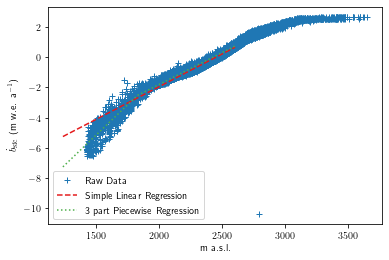

In [425]:
# N-Dimmentional piecewise regression
px, py = segments_fit(ZZ[~np.isnan(MB)],MB[~np.isnan(MB)], 3)
# Calculate the slopes of regressions
ms = (  py[1:] - py[:-1]) / (px[1:] - px[:-1])
# Calculate the y-intercepts of regressions
bs = (-(py[1:] - py[:-1]) / (px[1:] - px[:-1]) * px[:-1] + py[:-1])
# Make the piecewise line with the regssion data 
piese_wise = np.zeros_like(ss)
piese_wise[ss < px[1]]                  =  ms[0]* ss[ss < px[1]] + bs[0]
piese_wise[(px[1] < ss) & (ss < px[2])] =  ms[1]* ss[(px[1] < ss) & (ss < px[2])] + bs[1]
piese_wise[px[2]< ss]                   =  ms[2]* ss[px[2]< ss] + bs[2]

# Simple linear regression
m, b = lstq(ZZ[~np.isnan(MB)],MB[~np.isnan(MB)], 2)[::-1]

fig, ax = plt.subplots()

ax.plot(ZZ[~np.isnan(MB)],MB[~np.isnan(MB)], "+",label='Raw Data')

ax.plot(ss,np.polyval([m, b], ss),'--',color='#e41a1c',label='Simple Linear Regression')
ax.plot(ss,piese_wise,':',color='#4daf4a',label='3 part Piecewise Regression')
ax.legend()

ax.set_xlabel('m a.s.l.')
ax.set_ylabel('$\dot b_{\\rm{sfc}}$ (m w.e. a$^{-1}$)')


fig.savefig('../plots/mb_fit_test.png',dpi=250,bbox_inches='tight')

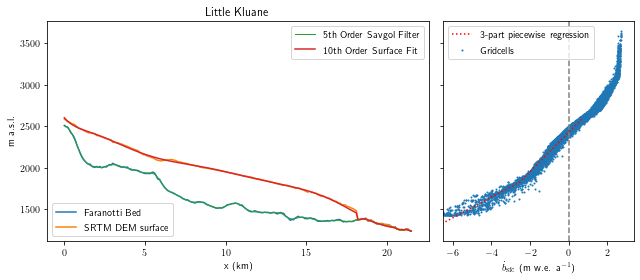

In [426]:
fig = plt.figure(figsize=(9.0,4.0))
gs  = GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharey=ax1)

# obs = []; fit = []
# obs += ax1.plot(xx,bedprof[::-1],label='Faranotti Bed')
# obs += ax1.plot(xx,surface[::-1],label='SRTM DEM surface')

# fit += ax1.plot(xx,bb[::-1],label='5th Order Savgol Filter',lw=1.0)
# fit += ax1.plot(xx,ss[::-1],label='10th Order Surface Fit')

obs = []; fit = []
obs += ax1.plot(xx,bedprof,label='Faranotti Bed')
obs += ax1.plot(xx,surface,label='SRTM DEM surface')

fit += ax1.plot(xx,bb,label='5th Order Savgol Filter',lw=1.0)
fit += ax1.plot(xx,ss,label='10th Order Surface Fit')


leg1 = ax1.legend(fit,[line.get_label() for line in fit],loc=1)
leg2 = ax1.legend(obs,[line.get_label() for line in obs],loc=3)
ax1.add_artist(leg1)

ax1.set_xlabel('x (km)')
ax1.set_ylabel('m a.s.l.')
ax1.set_title('Little Kluane')

ax2.scatter(MB,ZZ,s=1,label='Gridcells')
#ax2.plot(LK_CP['bdot'],LK_CP['surface'],'r',label='Flowline') 
ax2.plot(piese_wise,ss,'r:',label='3-part piecewise regression')
ax2.axvline(0,linestyle='--',color='grey')
ax2.set_xlabel('$\dot b_{\\rm{sfc}}$ (m w.e. a$^{-1}$)')
ax2.tick_params(labelleft=False)
ax2.set_xlim(-6.5,None)
ax2.legend()

fig.tight_layout()
fig.savefig('../Plots/lilklu.png',dpi=600,bbox_inches='tight')

## Save the extracted profiles

In [427]:
# write a new xx (x-cord) now in [m]
xx  = np.linspace(xx.min()*1e3,xx.max()*1e3,xx.shape[0])


In [428]:
np.savetxt('../Data/BedTopo.dat'   , np.array([xx,bb]).T,fmt='%.3e')
np.savetxt('../Data/SurfTopo.dat'  , np.array([xx,ss]).T,fmt='%.3e')
np.savetxt('../Data/SMB_debris.dat', np.array([xx,(piese_wise*1000.0/910.)]).T,fmt='%.3e')

In [429]:
!tail ../Data/BedTopo.dat

2.060e+04 2.217e+03
2.070e+04 2.263e+03
2.080e+04 2.309e+03
2.090e+04 2.354e+03
2.100e+04 2.396e+03
2.110e+04 2.433e+03
2.120e+04 2.463e+03
2.130e+04 2.485e+03
2.140e+04 2.499e+03
2.150e+04 2.504e+03


In [430]:
!tail ../Data/SMB_debris.dat

2.060e+04 2.356e-01
2.070e+04 2.764e-01
2.080e+04 3.210e-01
2.090e+04 3.700e-01
2.100e+04 4.244e-01
2.110e+04 4.853e-01
2.120e+04 5.538e-01
2.130e+04 6.311e-01
2.140e+04 7.188e-01
2.150e+04 8.183e-01


In [431]:
%%bash
start=$(awk 'NR==1 {print $1}' ../Data/SMB_debris.dat)
  end=$(awk 'END {print $1}'   ../Data/SMB_debris.dat)
    
echo $start
echo $end

0.000e+00
2.150e+04


In [432]:
!awk 'NR==1 {print $1}; END {print $1}' ../Data/SMB_debris.dat

0.000e+00
2.150e+04


In [433]:
!cat ../Data/SMB_debris.dat | wc -l 

     216


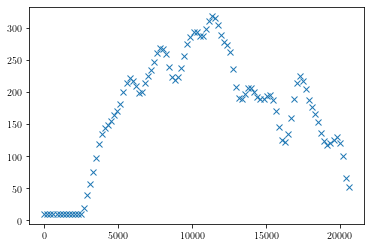

In [36]:
plt.plot(np.loadtxt('../test.dat')[:,4], np.loadtxt('../test.dat')[:,15] - np.loadtxt('../test.dat')[:,18],'x')

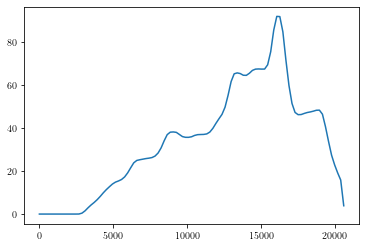

In [35]:
plt.plot(np.loadtxt('../test.dat')[:,4], np.sqrt(np.loadtxt('../test.dat')[:,8]**2 + np.loadtxt('../test.dat')[:,9]**2))

In [264]:
!cat ../Synthetic/SaveData/LK_PRE_1000a_MB_1.5_OFF.dat.names

Variables in file: ././Synthetic/SaveData/lk_pre_1000a_mb_1.5_off.dat
Elmer version: 9.0
Elmer revision: e63387d4
Elmer compilation date: 2020-11-20
Solver input file: sifs/stokes_prognostic.sif
File started at: 2021/02/20 17:10:27
Number of data nodes for each step
  bc nodes: 101
  polyline nodes: 0
  circle nodes: 0
  isocurve nodes: 0
Data on different columns
  1: Time step
  2: Iteration step
  3: Boundary condition
  4: Node index
  5: coordinate 1
  6: coordinate 2
  7: coordinate 3
  8: zs
  9: zbed
 10: velocity 1
 11: velocity 2


In [279]:
! cat ../test.dat | wc -l

cat: ../test.dat: No such file or directory
       0


In [280]:
dat = np.loadtxt('../Synthetic/SaveData/LK_PRE_1000a_MB_1.5_OFF.dat').reshape(-1,101,11)

dat[:,:,7][dat[:,:,7] < dat[:,:,8]+10] = dat[:,:,8][dat[:,:,7] < dat[:,:,8]+10]

In [292]:
dat.shape

(50, 101, 11)

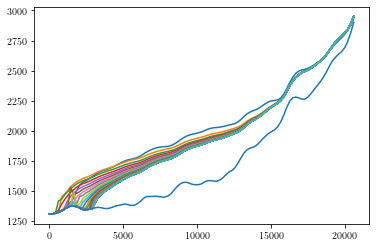

In [301]:
for t in range(dat.shape[0]):
    plt.plot(dat[t,:,4],dat[t,:,7])
    
plt.plot(dat[-1,:,4],dat[-1,:,8])


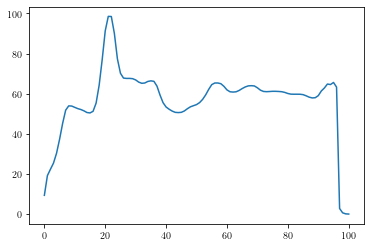

In [296]:
plt.plot(np.apply_along_axis(np.sqrt,0,dat[:,:,9]**2+ dat[:,:,10]**2)[1])

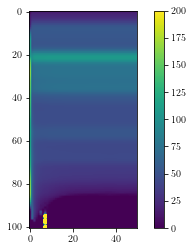

In [300]:
plt.imshow(np.apply_along_axis(np.sqrt,1,dat[:,:,9]**2+ dat[:,:,10]**2).T,clim=(0,200))
plt.colorbar()

In [274]:
np.sqrt(dat[:,:,9]**2+ dat[:,:,10]**2).shape

(31, 101)

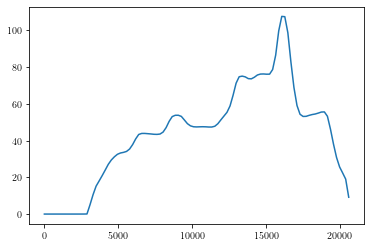

In [288]:
plt.plot(dat[-1,:,4],np.sqrt(dat[-1,:,9]**2+ dat[-1,:,10]**2))

In [289]:
dat[0:-1,:,7] - dat[1:,:,7]

array([[-2.16134303e+01, -1.22317944e+01, -9.80426527e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.51162710e-01,  1.73714350e-01, -1.34611630e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.24816000e-03, -5.83547000e-03, -2.03094000e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-9.99989425e-09,  5.29999852e-07,  1.32000014e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.00000317e-08,  4.00000317e-08,  1.60000127e-07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.00001692e-08, -4.79999926e-07, -1.06000016e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [290]:
import scipy.linalg as LA

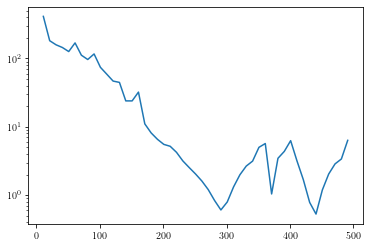

In [291]:
plt.yscale('log')
plt.plot(dat[1:,0,0],LA.norm(dat[0:-1,:,7] - dat[1:,:,7],axis=1))

In [167]:
dat[:,0,1]

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
       79., 80.])

In [380]:
1/0.1

10.0